## Prerequisites
```
sudo apt-get install python3-pip
sudo apt-get install python3-matplotlib
sudo apt-get install python3-mpltoolkits.basemap
sudo apt-get install python3-scipy python3-grib libgrib-api-dev 
pip3 install jupyter
pip3 install editdistance
pip3 install https://software.ecmwf.int/wiki/download/attachments/56664858/ecmwf-api-client-python.tgz
pip3 install pygrib

```

In [ ]:
# Download the french citites dataset
!curl http://freakonometrics.free.fr/popfr19752010.csv > french_cities.csv
!curl http://johmathe.nonutc.fr/presidentielles.tar.bz2 > presidentielles.tar.bz2
!tar -jxvf presidentielles.tar.bz2

In [8]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import Rbf
import csv
import editdistance
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#import pygrib
import unicodedata
import pygrib

FR_LATMIN = 40
FR_LATMAX = 53
FR_LONMIN = -7
FR_LONMAX = 10

# Useful CSV fields
PARTICIPATION_ID = 13
CITY_ID = 3
file_mappings = {2007: 'presidentielles_data/presidentielles_2007.csv.0',
                 2012: 'presidentielles_data/presidentielles_2012.csv.0',
                 2002: 'presidentielles_data/presidentielles_2002_1ertour.csv.0'}

election_dates = {2007: '2007-04-22',
                  2012: '2012-04-22',
                  2002: '2002-04-21'}
ELECTIONS = {}

for y, f in file_mappings.items():
    print('Reading election file for year', y)
    with open(f) as fd:
        csvreader = csv.reader(fd)
        for r in csvreader:
            ELECTIONS.setdefault(y, []).append(r)
    
    
# Skip the first row - csv header
ELECTION_CITIES = [e[CITY_ID] for e in ELECTIONS[2007][1:]]

Reading election file for year 2002
Reading election file for year 2012
Reading election file for year 2007


In [60]:
# defining some plotting utilities
from ecmwfapi import ECMWFDataServer
import os

def remove_accents(input_str):
    """Remove accents and other annoyances :)"""
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u''.join([c for c in nfkd_form if not unicodedata.combining(c)])


def normalize_city_to_latlon(elections):
    """Take elections data structure, and return the lat/lon of various cities."""
    cities = []
    with open('french_cities.csv') as f:
        csvreader = csv.reader(f)
        for r in csvreader:
            cities.append(r)
    city_dic = {}
    
    # Skip the first row - csv header
    for c in cities[1:]:
        city_name = remove_accents(c[3].lower() + c[4].lower())
        city_dic[city_name] = (c[5], c[6])
    misses = 0
    city_to_latlon = {}
    for e in elections[1:]:
        try:
            city_name = remove_accents(e[CITY_ID].lower())
            city_to_latlon[e[CITY_ID]] = city_dic[city_name]
        except KeyError:
            distances = []
            for city in city_dic:
                distances.append((editdistance.eval(city, city_name), city))
            best_city = min(distances)
            if best_city[0] > 1:
                misses += 1
            else:
                city_to_latlon[e[CITY_ID]] = city_dic[best_city[1]]
    print('Missed', misses, 'cities.')
    assert(misses < 1000)
    return city_to_latlon


def kelvin_to_celsius(values):
    """Convert Kelvin to Celcius."""
    return values - 273.15


def build_temperature_interpolator_for_day(date):
    """Fetch and retrieve temperature interpolator for a given day."""
    filename = date + 'prec6'
    if not os.path.exists(filename):
        server = ECMWFDataServer()
        server.retrieve({
            "class": "ei",
            "dataset": "interim",
            "date": "%s" % date,
            "expver": "1",
            "grid": "0.75/0.75",
            "levtype": "sfc",
            "param": "228.128",
            "step": "6",
            "stream": "oper",
            "time": "12:00:00",
            "type": "fc",
            "target": "%s" % filename,
        })
    else:
        print('cached file found!')
    grbs = pygrib.open(filename)
    
    for grb in grbs:
        pass

    data = kelvin_to_celsius(grb.values)
    lat,lon = grb.latlons()

    
    newlats = []
    newlons = []
    newdata = []
    for i, la in enumerate(lat.flatten()):
        # Wraparound longitudes
        lo = lon.flatten()[i]
        if lo > 180:
            lo -= 360
        if (la > FR_LATMIN and la < FR_LATMAX
            and lo > FR_LONMIN and lo < FR_LONMAX):
            newlats.append(la)
            newlons.append(lo)
            newdata.append(data.flatten()[i])

    return Rbf(newlons, newlats, newdata, function='linear')


def plot_france_locations(locations,
                          vmin=None,
                          vmax=None,
                          scale='LogNorm',
                          title=''):
    """
    :locations: [(lat, lon, data), ...]
    """
    # setup mercator map projection.
    m = Basemap(llcrnrlon=FR_LONMIN,
                llcrnrlat=FR_LATMIN,
                urcrnrlon=FR_LONMAX,
                urcrnrlat=FR_LATMAX,
                rsphere=(6378137.00, 6356752.3142),
                resolution='h',
                projection='merc')

    m.drawcoastlines()
    m.fillcontinents()
    m.drawparallels(np.arange(10, 90, 2), labels=[1, 1, 0, 1])
    m.drawmeridians(np.arange(-180, 180, 2), labels=[1, 1, 0, 1])
    

    lats = [float(c[0]) for c in locations]
    lons = [float(c[1]) for c in locations]
    data = [float(c[2]) for c in locations]

    # Normalize with regards to log of the population.
    if vmin is None:
        vmin = 1
    if vmax is None:
        vmax = max(data)
    if scale is 'LogNorm':
        norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
        data = [d + 1 for d in data]
    else:
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    # Do the actual plot.
    cmap = matplotlib.cm.get_cmap('hot')
    for i, (d, lat, lon) in enumerate(zip(data, lats, lons)):
        # pop = myrbf(lon, lat)
        x, y = m(lat, lon)
        m.plot(x, y, '.', color=cmap(norm(d)), markersize=1)

    # A colorbar. That was extremely painful. Thank you internet.
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    plt.colorbar(sm)


def plot_elections_participation(elections_data, title=''):
    participations = [float(e[PARTICIPATION_ID]) for e in elections_data[1:]]

    latlon_val = []
    for e in elections_data[1:]:
        try:
            latlon_val.append(NORMALIZED_LATLONS[e[CITY_ID]] + (float(e[
                PARTICIPATION_ID]), ))
        except KeyError:
            pass
    sigma = np.std(participations)
    mu = np.mean(participations)
    # Upper and lower bounds of the graph.
    vmin = mu - 2*sigma
    vmax = mu + 2*sigma
    plot_france_locations(latlon_val,
                          vmin,
                          vmax,
                          scale='Normalize',
                          title=title)
    
    plt.title(title)
    return latlon_val


def plot_temperature_for_day(date, title=''):
    latlon_val = []
    interp = build_temperature_interpolator_for_day(date)
    
    for e in ELECTIONS[2007]:
        try:
            latlon_val.append(NORMALIZED_LATLONS[e[CITY_ID]] + (interp(*NORMALIZED_LATLONS[e[CITY_ID]]),))
        except KeyError:
            pass

    vals = [val[2] for val in latlon_val]
    sigma = np.std(vals)
    mu = np.mean(vals)
    vmin = mu - 2*sigma
    vmax = mu + 2*sigma
    plot_france_locations(latlon_val,
                          vmin,
                          vmax,
                          scale='Normalize',
                          title=title)
    plt.title(title)
    return latlon_val

In [12]:
# Clean up the city keys. This code is pretty slow, so keep the
# normalized_latlons in memory and don't call the normalization
# funciton often.
NORMALIZED_LATLONS = normalize_city_to_latlon(ELECTIONS[2007][1:])

Missed 363 cities.


cached file found!
cached file found!
cached file found!


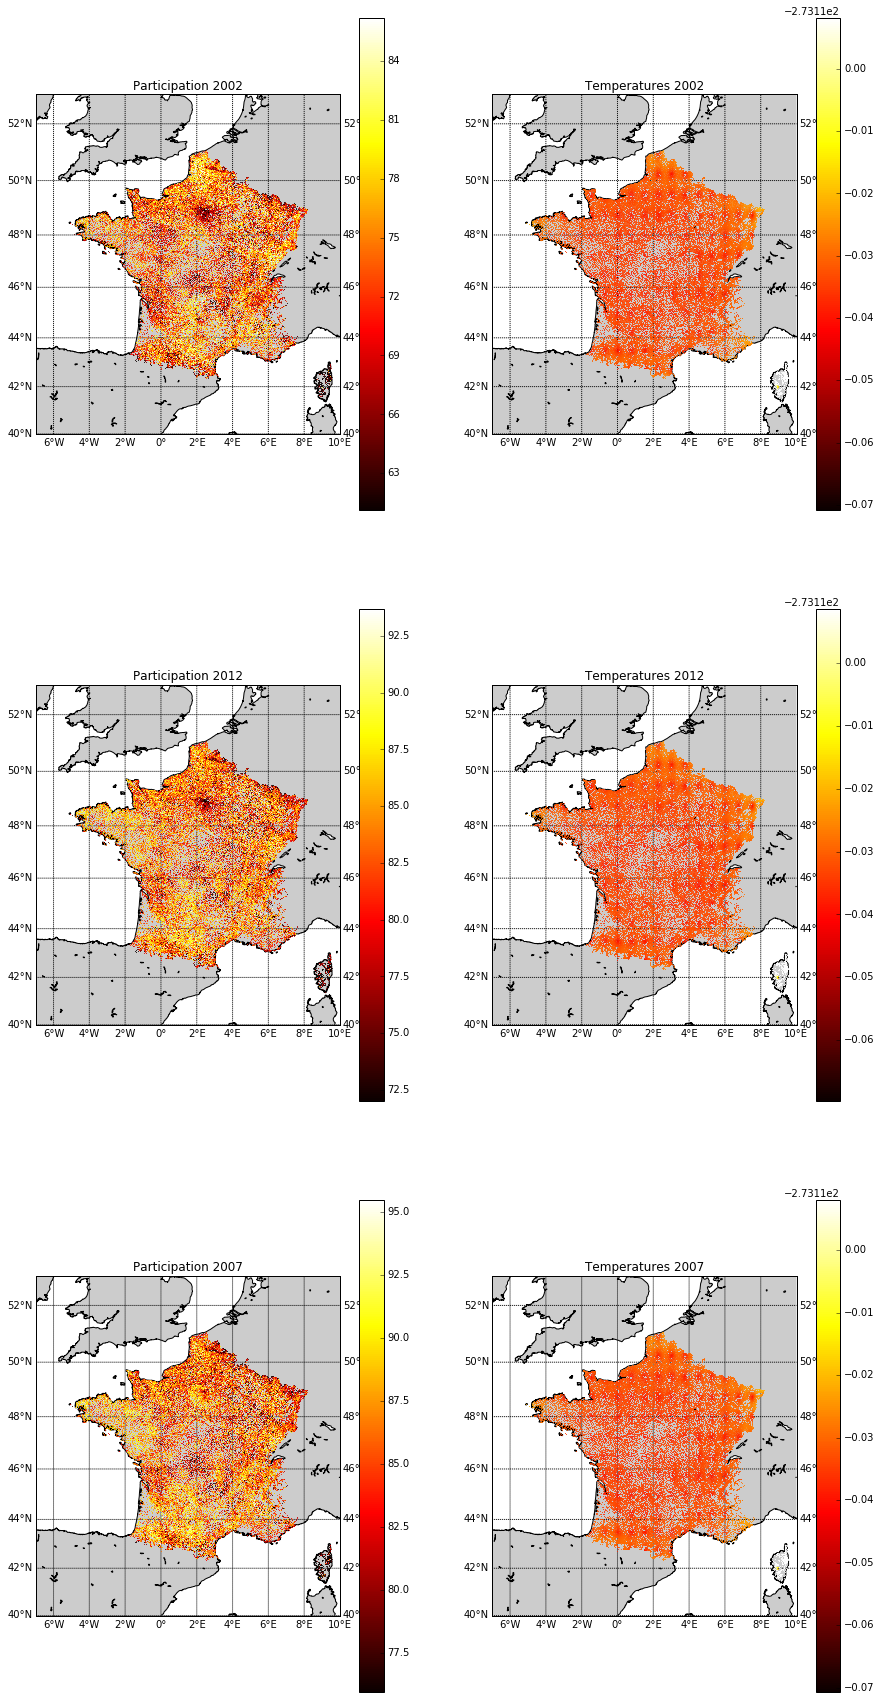

In [61]:
# Plot the whole thing, keep the participation and temperature data
# for further analysis. 
# The following procedure can take up to 15 minutes and requires tons of RAM
participation_data = {}
temp_data = {}
rows = len(ELECTIONS)

plt.figure(figsize=(15,30))

for i, (year, data) in enumerate(ELECTIONS.items()):
    plt.subplot(rows, 2, 2*i+1)
    participation_data[year] = plot_elections_participation(data, title='Participation %s' % year)
    plt.subplot(rows, 2, 2*i+2)
    temp_data[year] = plot_temperature_for_day(election_dates[year], title='Temperatures %s' % year)
    

In [ ]:
# Plot histograms for temperatures and voting rate.
plt.figure(figsize=(15,13))
for i, y in enumerate([2002, 2007, 2012]):
    plt.subplot(len(ELECTIONS), 1, i + 1)
    part_data = [d[2] for d in participation_data[y]]
    plt.hist(part_data, 150, label='participation')
    temp_data2 = [d[2] for d in temp_data[y]]
    plt.hist(temp_data2, 30, label='precipitation')
    plt.legend(['temperature', 'participation'])
    plt.title('Histogram of temperature and participation rate for year %s' % y)
    plt.xlim(1, 100)
    plt.grid()
    print('participation - year:', y, 'mean:', np.mean(part_data), 'stddev:', np.std(part_data))
    print('temperature - year:', y, 'mean:', np.mean(temp_data2), 'stddev:', np.std(temp_data2))
    


SpearmanrResult(correlation=0.026639885897097853, pvalue=2.0406096080119174e-06)
SpearmanrResult(correlation=-0.052680108417183305, pvalue=5.3314065447530424e-21)
SpearmanrResult(correlation=-0.064926543425057187, pvalue=4.5911357124680526e-31)


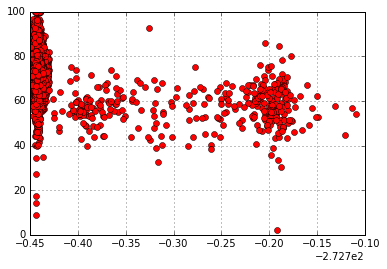

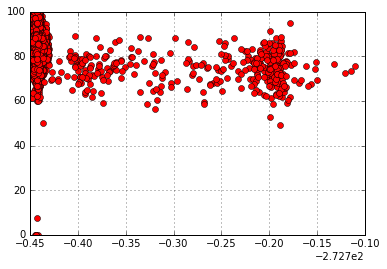

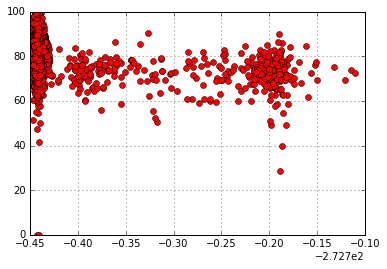

In [63]:
import scipy.stats

misses = 0
points = {}
for i, y in enumerate([2002, 2007, 2012]):
    for p in temp_data[y]:
        points[(p[0], p[1])] = [float(p[2])]
    for p in participation_data[y]:
        try:
            points[(p[0], p[1])].append(float(p[2]))
        except KeyError:
            misses += 1
    final_points = []
    for k, p in points.items():
        if len(p) == 2:
            final_points.append(p) 
    plt.figure()
    x = [p[0] for p in final_points]
    y = [p[1] for p in final_points]
    print(scipy.stats.spearmanr(x, y))
    plt.plot(x, y, 'ro')
    plt.grid()